## Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path
from genometechlab_plotting import setup_style, get_colors
setup_style("inline")
plot_colors = get_colors()

Loaded 7 Helvetica fonts


## Define Mod Codes

In [2]:
MOD_CODES = {
    'a': 'm6A',
    'm': 'm5C',
    '17802': 'Psi',
    '17596': 'Ino'
}

## Data Loading Function

In [3]:
def load_and_filter_data(pickle_path, min_score=20, min_mod_percent=20):
    print(f"Loading data from: {pickle_path}")
    df = pd.read_pickle(pickle_path)
    print(f"  Total rows loaded: {len(df):,}")

    df['mod'] = df['mod'].astype(str)

    df_filtered = df[
        (df['mod'].isin(MOD_CODES.keys())) &
        (df['score'] >= min_score) & 
        (df['fp_adjusted_mod_percent'] >= min_mod_percent)
    ].copy()
    
    print(f"  After filtering (target mods, score >= {min_score}, mod% >= {min_mod_percent}): {len(df_filtered):,} rows")
    
    for mod_code, mod_name in MOD_CODES.items():
        count = (df_filtered['mod'] == mod_code).sum()
        print(f"    {mod_name} ({mod_code}): {count:,} sites")
    
    return df_filtered

## Plotting Function

In [4]:
def plot_distributions_grouped(df, sample_name, output_path=None):
    fig, ax = plt.subplots(figsize=(14, 8))
    bins = np.arange(20, 110, 10)
    bin_labels = [f'{i}' for i in bins[:-1]]
    
    mod_colors = {
        'a': plot_colors[0],
        'm': plot_colors[3],
        '17802': plot_colors[1],
        '17596': plot_colors[2]
    }
    
    hist_data = {}
    for mod_code, mod_name in MOD_CODES.items():
        mod_data = df[df['mod'] == mod_code]['fp_adjusted_mod_percent']
        if len(mod_data) > 0:
            counts, _ = np.histogram(mod_data, bins=bins)
            hist_data[mod_name] = counts
        else:
            hist_data[mod_name] = np.zeros(len(bins) - 1)
    
    n_bins = len(bin_labels)
    n_mods = len(MOD_CODES)
    total_bars = n_bins * n_mods
    bar_width = 1.0
    all_positions = np.arange(total_bars)
    
    for mod_idx, (mod_code, mod_name) in enumerate(MOD_CODES.items()):
        positions = np.arange(mod_idx, total_bars, n_mods)
        counts = hist_data[mod_name]
        
        bars = ax.bar(positions, counts, bar_width,
                      label=mod_name,
                      color=mod_colors[mod_code],
                      alpha=0.8,
                      edgecolor='black',
                      linewidth=0.5)
    
    ax.set_yscale('log')
    ax.set_xlabel('Percent Modification at a Given Site', fontsize=12)
    ax.set_ylabel('Site Count', fontsize=12)
    ax.set_title(f'{sample_name}\nRNA Modification Distribution Comparison', 
                fontsize=16, fontweight='bold')
    
    group_centers = np.arange(n_mods/2 - 0.5, total_bars, n_mods)
    ax.set_xticks(group_centers)
    ax.set_xticklabels(bin_labels)
    
    ax.legend(title='mod', loc='upper right', frameon=True)
    ax.grid(True, alpha=0.3, axis='y', which='both')
    ax.set_ylim(bottom=1, top=10**6)
    
    ax.yaxis.set_minor_locator(plt.LogLocator(base=10, subs='all'))
    ax.grid(True, alpha=0.1, axis='y', which='minor')
    ax.set_xlim(-0.5, total_bars - 0.5)
    
    if output_path:
        with PdfPages(output_path) as pdf:
            pdf.savefig(fig, bbox_inches='tight')
        print(f"\nPlot saved to: {output_path}")
    else:
        plt.show()

## Summary Statistics Function

In [5]:
def print_summary_statistics(df_filtered):
    print(f"\nSummary statistics:")
    print(f"  Total sites: {len(df_filtered):,}")
    print(f"  Unique genes: {df_filtered['gene_id'].nunique() if 'gene_id' in df_filtered.columns else 'N/A'}")
    print("\nPercentile distributions:")
    for mod_code, mod_name in MOD_CODES.items():
        mod_data = df_filtered[df_filtered['mod'] == mod_code]['fp_adjusted_mod_percent']
        if len(mod_data) > 0:
            print(f"  {mod_name}:")
            for p in [25, 50, 75, 90]:
                val = mod_data.quantile(p/100)
                print(f"    {p}th percentile: {val:.1f}%")

## Paths

In [6]:
INPUT_FILE = '../Exemplar_Data/annotated_output/pickle_output/08_07_24_GM12878_chr12-112000000-114000000_annotated_valid_kmer.pkl'
SAMPLE_NAME = "08_07_24_GM12878_chr12-112000000-114000000"  # Set to None to auto-generate from filename
OUTPUT_PDF = None   # Set to file path to save PDF, or None to display inline
MIN_SCORE = 20
MIN_MOD_PERCENT = 20

## Run Analysis

Loading data from: ../Exemplar_Data/annotated_output/pickle_output/08_07_24_GM12878_chr12-112000000-114000000_annotated_valid_kmer.pkl
  Total rows loaded: 172
  After filtering (target mods, score >= 20, mod% >= 20): 165 rows
    m6A (a): 105 sites
    m5C (m): 44 sites
    Psi (17802): 2 sites
    Ino (17596): 14 sites

Summary statistics:
  Total sites: 165
  Unique genes: 17

Percentile distributions:
  m6A:
    25th percentile: 27.1%
    50th percentile: 38.6%
    75th percentile: 62.6%
    90th percentile: 83.5%
  m5C:
    25th percentile: 22.5%
    50th percentile: 31.1%
    75th percentile: 41.1%
    90th percentile: 50.7%
  Psi:
    25th percentile: 31.8%
    50th percentile: 37.2%
    75th percentile: 42.7%
    90th percentile: 45.9%
  Ino:
    25th percentile: 21.5%
    50th percentile: 24.5%
    75th percentile: 25.5%
    90th percentile: 29.1%


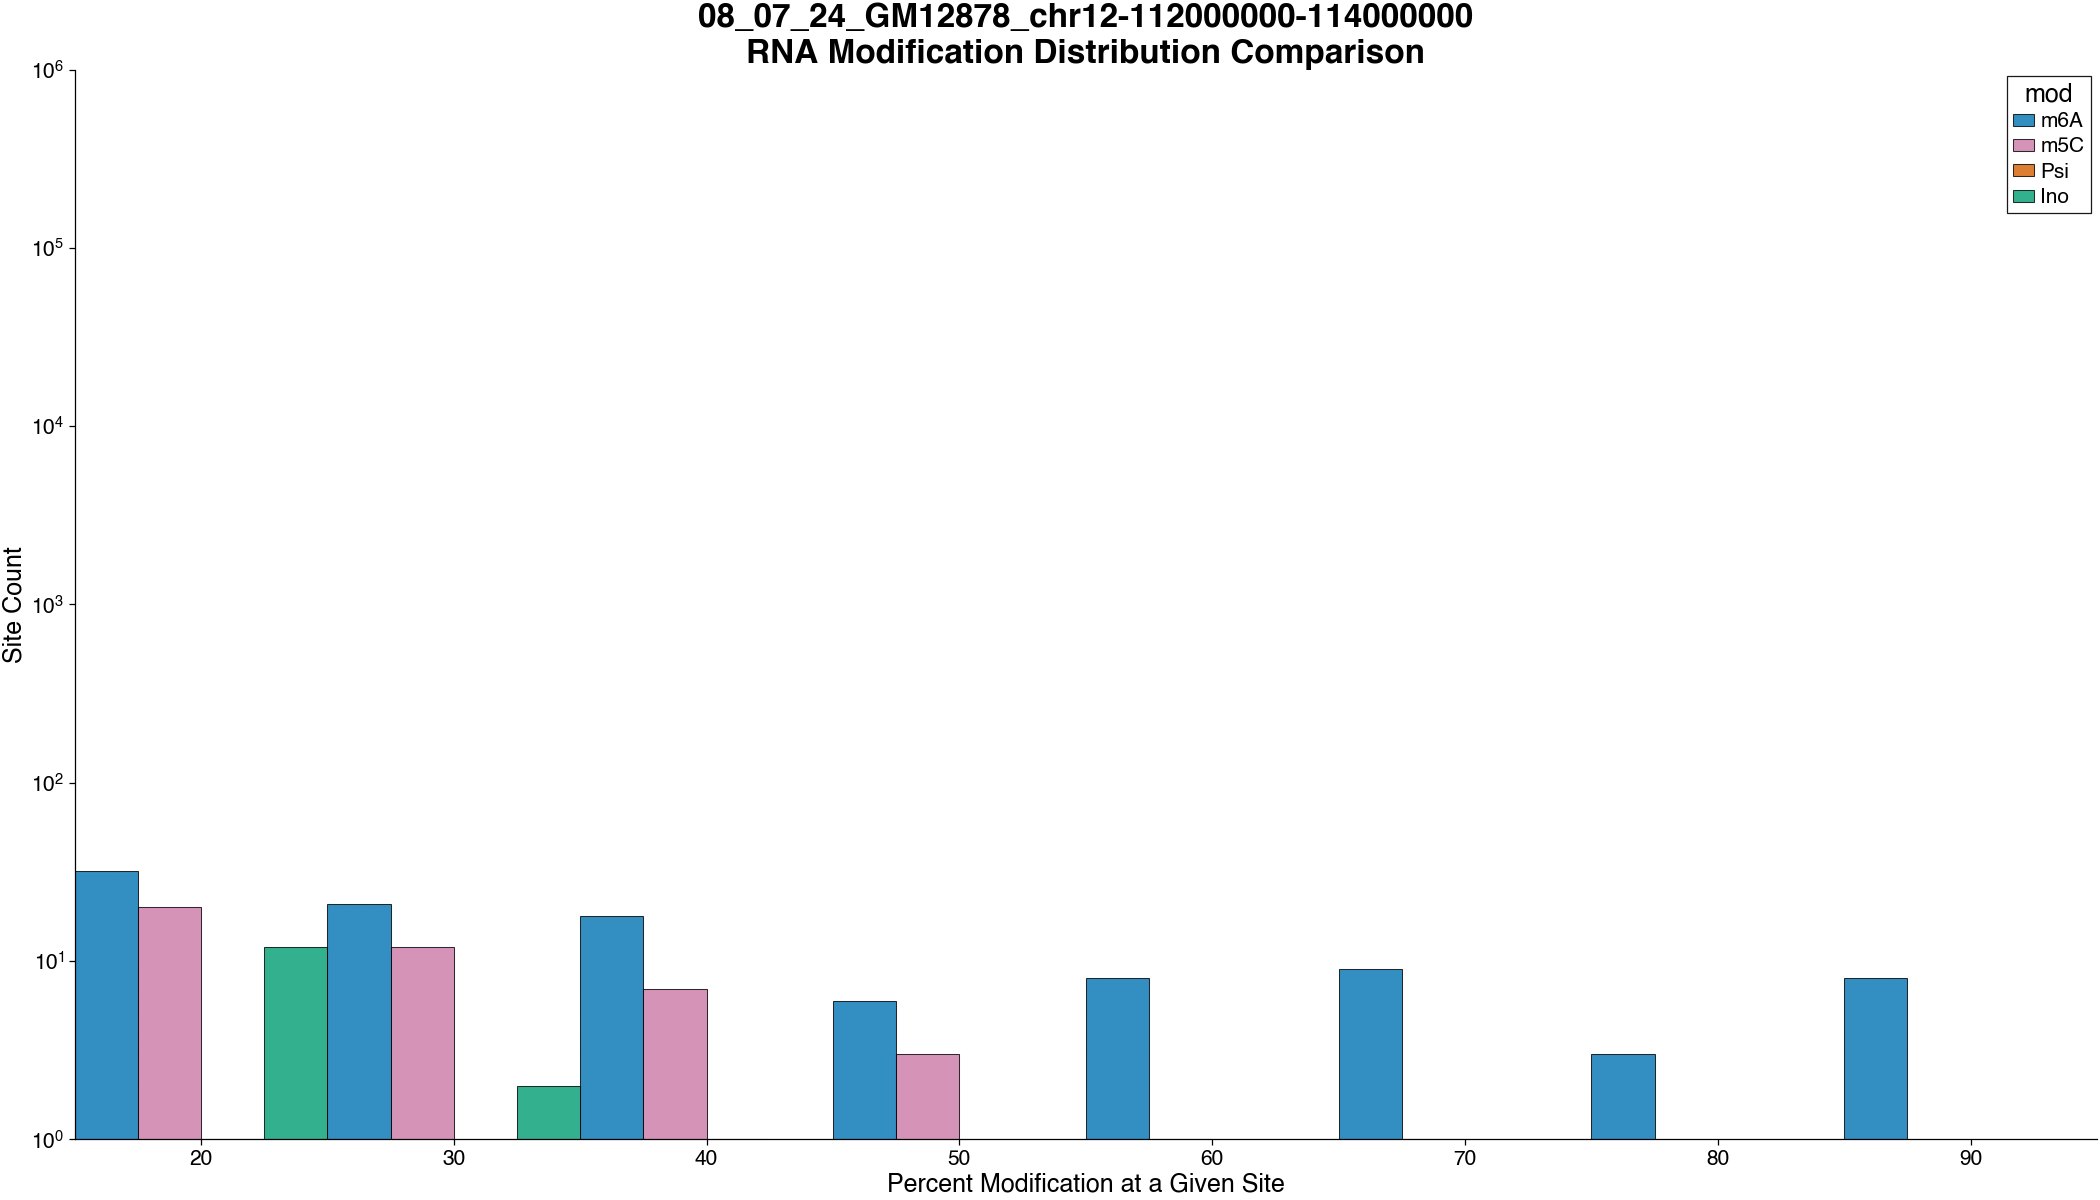

In [7]:
%matplotlib inline
if SAMPLE_NAME is None:
    SAMPLE_NAME = Path(INPUT_FILE).stem.replace('_annotated_valid_kmer', '')

df_filtered = load_and_filter_data(INPUT_FILE, MIN_SCORE, MIN_MOD_PERCENT)

print_summary_statistics(df_filtered)

plot_distributions_grouped(df_filtered, SAMPLE_NAME, OUTPUT_PDF)